# Setup

In [543]:
import pandas as pd
from pandas.api.types import CategoricalDtype, is_categorical_dtype
import numpy as np
from plotnine import *
import plotnine
import matplotlib as mp
import scipy.stats as ss
import warnings
warnings.filterwarnings('ignore')

def convert_params(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    var = mu + theta * mu ** 2
    p = (var - mu) / var
    return theta, 1 - p


# Background and motivation
Metagenomics is important because XXX.
Sequencing sensitivity/depth is inherently proportional to input DNA species abundance.
Therefore, detection of rare DNA species requires expensive, ultra-high depth sequencing.

# Objective
To reduce cost and increase sensitivity, I propose using a simple based-based depletion strategy to remove high-abundance DNA species from a metagenomic NGS library.

# Approach
This approach was designed to be agnostic of the input DNA content.
This approach uses completed NGS libraries as input; thus, requiring minimal changes to molecular biology workflows.
According to Castle et al. (10.1094/PBIOMES-09-17-0037-R), a 1:10 dilution followed by amplification of a soil fungal metagenome library resulted in approximately 20% loss of diversity. 
Their analysis showed that that low-abundance species in an undiluted control were the depleted constituents during the dilution step.
DNA capture probes created from this biased library would reflect the DNA abundance distribution of the input metagenome excluding ca. 20% of low-abundance species. 
Therefore, upon depleting the input library with above capture probes, the resultant library will be depleted of high-abundance species.
Sequencing of this depleted library will be more cost-efficient and sensitive because reads will be allocated to rare species.


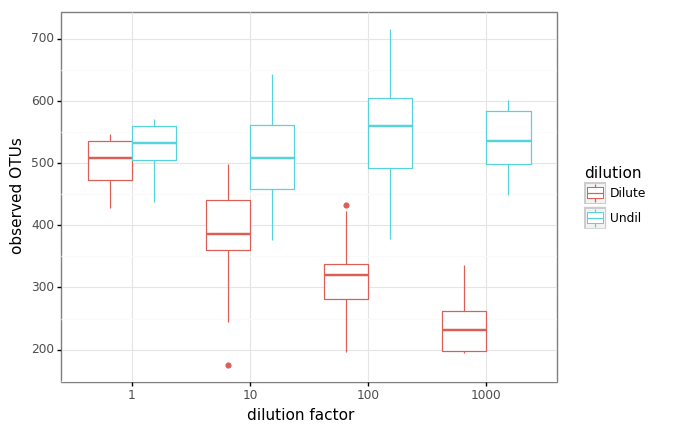

<ggplot: (8755800271045)>


dilution,Dilute,Undil,fraction_depleted
dil_factor,,,
1,508.5,532.5,0.045070
10,386.5,508.0,0.239173
100,320.0,559.0,0.427549
1000,231.0,535.0,0.568224


In [544]:
# ingest published data
supp_df = pd.read_csv('s3://daniel.le-work/deplete_seq/Castle_etal_2018_qpcr.csv')
supp_df['dil_factor'] = supp_df['dil_factor'].astype(str)

# boxplots of observed OTUs
print(ggplot(supp_df)
      + theme_bw()
      + geom_boxplot(aes('dil_factor','observed OTUs', color = 'dilution'))
      + labs(x='dilution factor')
     )

# table of observed OTUs
ratio_df = (supp_df
            .drop('molecules (measured or estimated)', axis=1)
            .groupby(['dil_factor','dilution'])
            .median()
            .reset_index()
            .pivot(index = 'dil_factor', columns='dilution', values = 'observed OTUs'))
ratio_df['fraction_depleted'] = 1 - (ratio_df.Dilute / ratio_df.Undil)
display(ratio_df)


# Proposed method
An adaptation of Roche NimbleGen SeqCap EZ protocol: 10.1002/0471142727.mb0721s112

## Step 1: Dilute
The target NGS library (conc. TBD) is sampled and placed into dilution buffer, resulting in 1:>10 final dilution. 

## Step 2: Amplify and biotinylate
Amplify diluted library with R1/R2 primers that contain 5'-biotin tag. 
 
## Step 3: Capture
Hybridize capture probes to input solution: melt and slow anneal.

## Step 4: Deplete
Add magnetic steptavidin-coated beads to capture pool. Supernatant = final library.

# Simulated results

## Simulated input
Assume negative binomial distribution of species abundance.

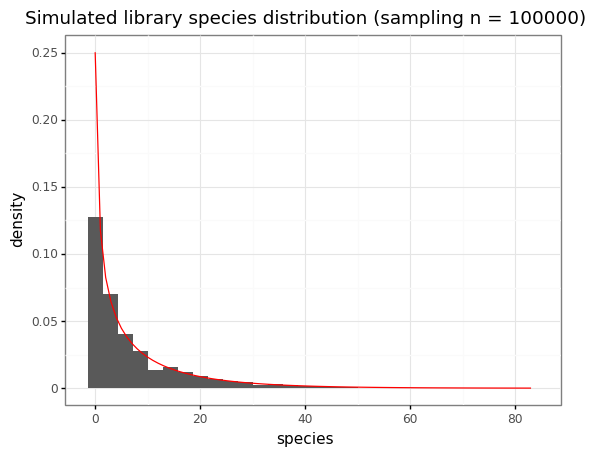

<ggplot: (-9223363281053783748)>


In [567]:
# assume negative binomial expression level distribution
n, p = convert_params(30,0.5)
species = np.arange(ss.nbinom.ppf(0.001, n, p),ss.nbinom.ppf(0.999, n, p)) # Percent point function (inverse of cdf — percentiles)
species = species - np.min(species)
rv = ss.nbinom(n, p) # Random variates
prob = rv.pmf(species) # Probability mass function (function that describes probs for discrete variables)
prob = prob/sum(prob)
sample_size = 100000

# original distribution
raw_counts_df = pd.DataFrame(
                              pd.Series(
                                  np.random.choice(species, 
                                                   size = sample_size, 
                                                   p = prob)
                              )).rename(columns = {0:'species'})

# probs by species
theoretical_df = pd.DataFrame({'original_prob':prob,
                               'species':species
                              })
theoretical_df['species'] = theoretical_df['species'].astype(int)

# counts by species
theoretical_df = pd.merge(theoretical_df,(raw_counts_df['species']
                                          .value_counts()
                                          .reset_index()
                                          .rename(columns = {'species':'original_counts',
                                                             'index':'species'})
                                         ),
                          'left',
                          'species'
                         )
theoretical_df['original_counts'] = theoretical_df['original_counts'].replace(np.nan, 0)

print(ggplot()
      + theme_bw()
      + geom_histogram(raw_counts_df, aes('species', '..density..'), bins = 30)
      + geom_line(theoretical_df, aes('species', 'original_prob'), color = 'red')
      + labs(x = 'species', y = 'density')
      + ggtitle(f'Simulated library species distribution (sampling n = {sample_size})')
     )



## Simulated output
Assume uniform reduction of respective sampling probabilities such that the proportion of depleted species is equal to that reported in above literature for a given dilution factor.

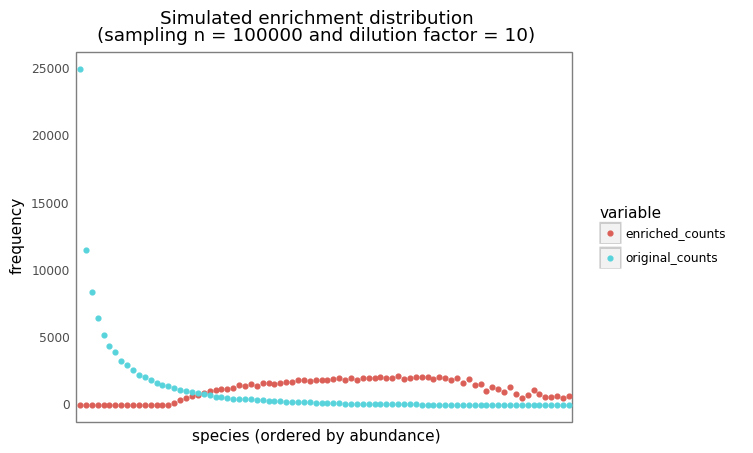

<ggplot: (8755800499923)>


In [568]:
# depleted population based on expectation from literature
dilution_factor = 10 
depletion_fraction = ratio_df[[x == str(dilution_factor) for x in ratio_df.index]]['fraction_depleted'].values[0]
theoretical_df = theoretical_df.sort_values('original_prob')
theoretical_df['keep_species'] = True
theoretical_df.loc[:int(len(theoretical_df) * (1-depletion_fraction)),'keep_species'] = False

# capture prob
## uniform decrease in prob by threshold percentile value
uniform_loss = theoretical_df[theoretical_df.keep_species == False]['original_prob'].max()
theoretical_df['capature_prob'] = theoretical_df['original_prob'] - uniform_loss
theoretical_df['capature_prob'] = [x if x > 0 else 0 for x in theoretical_df['capature_prob']]
theoretical_df['capature_prob'] = theoretical_df['capature_prob']/theoretical_df['capature_prob'].sum()

# post depletion prob and counts
theoretical_df['enriched_prob'] = theoretical_df['original_prob'] - theoretical_df['capature_prob']
theoretical_df['enriched_prob'] = [x if x > 0 else 0 for x in theoretical_df['enriched_prob']]
theoretical_df['enriched_prob'] = theoretical_df['enriched_prob'] / theoretical_df['enriched_prob'].sum()
theoretical_df = theoretical_df.sort_values('species')
theoretical_df = pd.merge(theoretical_df,
                          pd.DataFrame(
                              pd.Series(
                                  np.random.choice(species, 
                                                   size = sample_size, 
                                                   p = theoretical_df['enriched_prob'].values)
                              ).value_counts()
                          )
                          .reset_index()
                          .rename(columns = {0:'enriched_counts',
                                             'index':'species'}),
                          'left',
                          'species'
                         )
theoretical_df['enriched_counts'] = theoretical_df['enriched_counts'].replace(np.nan, 0)

# Plot showing enrichment vs original counts
plot_df = theoretical_df.sort_values('original_counts', ascending = False)
plot_df['species_cat'] = (plot_df['species']
                          .astype(str)
                          .astype(CategoricalDtype(plot_df['species'].astype(str).values.tolist(), ordered=True))
                         )
plot_df = pd.melt(plot_df, value_vars=['enriched_counts','original_counts'], id_vars=['species_cat'])

print(ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_blank(),
              axis_ticks = element_blank(),
              panel_grid = element_blank()
             )
      + geom_point(aes('species_cat', 'value', color = 'variable'))
      + labs(x='species (ordered by abundance)', y='frequency')
      + ggtitle(f'Simulated enrichment distribution\n(sampling n = {sample_size} and dilution factor = {dilution_factor})')
     )

# Proof-of-concept plan (TBD)
Create detailed protocol.
Determine efficiency and robustness of protocol.